In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(237)  # for reproducibility

In [2]:
class CatDogDataset(Dataset):
    def __init__(self, root_dir, file_list, transform=None):
        self.root_dir = root_dir
        self.files = file_list
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filename = self.files[idx]
        path = os.path.join(self.root_dir, filename)

        img = Image.open(path).convert("RGB")

        if "cat" in filename.lower():
            label = 0
        else:
            label = 1

        if self.transform:
            img = self.transform(img)

        return img, label

In [3]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


    
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

root = "data/catdog/train"
files = os.listdir(root)
files = [f for f in files if f.lower().endswith(("jpg","jpeg","png"))]

# 파일명 → 라벨
labels = []
for f in files:
    if "cat" in f.lower():
        labels.append(0)
    else:
        labels.append(1)

labels = np.array(labels)
files  = np.array(files)

# ---------------------------------------
# ⭐ Stratified Train / Val / Test Split
# ---------------------------------------

# 1) 먼저 train vs temp (val+test)
train_files, temp_files, train_labels, temp_labels = train_test_split(
    files, labels, test_size=0.3, stratify=labels, random_state=42
)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

trainset = CatDogDataset(root, train_files, transform)
testset   = CatDogDataset(root, temp_files, transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader   = DataLoader(testset, batch_size=64, shuffle=False)

In [4]:
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")

train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Image shape: torch.Size([3, 224, 224])
Label: 1
Train dataset size: 17500 (Shape: torch.Size([]))
Test dataset size: 7500 (Shape: torch.Size([]))


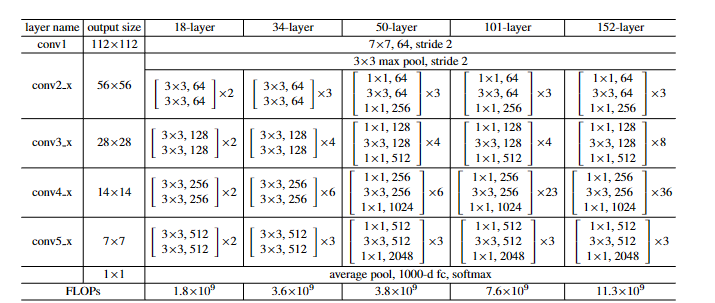

In [5]:
class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, skip=True):
        super().__init__()
        self.skip = skip
        
        self.conv1 = nn.Conv2d(in_channel, out_channel, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channel)
        
        self.conv2 = nn.Conv2d(out_channel, out_channel, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channel)
        
        # downsample = Conv1x1 + BN (stride 반영)
        if skip and (stride != 1 or in_channel != out_channel):
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.downsample = None

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.skip:
            if self.downsample is not None:
                identity = self.downsample(identity)
            out += identity

        out = self.relu(out)
        return out

class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channel, mid_channel, stride=1, skip=True):
        super().__init__()
        self.skip = skip

        # conv1 (1x1)
        self.conv1 = nn.Conv2d(in_channel, mid_channel, 1, stride=stride, bias=False)
        self.bn1   = nn.BatchNorm2d(mid_channel)

        # conv2 (3x3)
        self.conv2 = nn.Conv2d(mid_channel, mid_channel, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(mid_channel)

        # conv3 (1x1)
        self.conv3 = nn.Conv2d(mid_channel, mid_channel * self.expansion, 1, bias=False)
        self.bn3   = nn.BatchNorm2d(mid_channel * self.expansion)

        # downsample ● conv1x1 with BN
        out_channel = mid_channel * self.expansion
        if skip and (stride != 1 or in_channel != out_channel):
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.downsample = None

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.skip:
            if self.downsample is not None:
                identity = self.downsample(identity)
            out += identity

        out = self.relu(out)
        return out

In [6]:
# Resnet 모델 자체를 생성하는 클래스입니다.
class RESnet(nn.Module):
    def __init__(self,num_list = [3,4,6,3] ,skip_connection = True, num_classes=2, bottleneck = False):
        super(RESnet, self).__init__()

        layers = [
            nn.Conv2d(3,64,kernel_size=7,padding=3),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2) 
        ]
        channel_list = [64,128,256,512]
        pre_channel = 64
        stride = 1
        for i, (num_blocks, channel) in enumerate(zip(num_list,channel_list)):              
            for j in range(num_blocks):
                if (j == 0) and (i != 0):
                    stride = 2
                    pre_channel = channel_list[i-1] if not bottleneck else 2*channel_list[i] 
                elif (j != 0):
                    stride = 1
                    pre_channel = channel_list[i] if not bottleneck else 4*channel_list[i]
                if bottleneck:
                    layers.append(BottleneckBlock(pre_channel,channel, stride, skip_connection))
                else :
                    layers.append(BasicBlock(pre_channel,channel, stride, skip_connection))
                    
        
        
        c = 2048 if bottleneck else 512
            
        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1),
            nn.Linear(c, num_classes)
        )



    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [7]:
resnet34 = RESnet()
plain34 = RESnet(skip_connection=False)
resnet34(torch.rand((1,3,224,224)))
plain34(torch.rand((1,3,224,224)))
print(resnet34)

RESnet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (4): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05,

In [8]:
resnet50 = RESnet(num_list=[3,4,6,3],bottleneck=True)
plain50 = RESnet(bottleneck=True,skip_connection=False)
resnet50(torch.rand((1,3,224,224)))
plain50(torch.rand((1,3,224,224)))
print(resnet50)

RESnet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (

C:\Users\tkdwl\AppData\Local\Temp\ipykernel_199772\3865527952.py:40: UserWarning: Glyph 44618 (\N{HANGUL SYLLABLE GIP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tkdwl\AppData\Local\Temp\ipykernel_199772\3865527952.py:40: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tkdwl\AppData\Local\Temp\ipykernel_199772\3865527952.py:40: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tkdwl\AppData\Local\Temp\ipykernel_199772\3865527952.py:40: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44618 (\N{HANGUL SYLLABLE GIP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\IPython\core\pylabtools.py:1

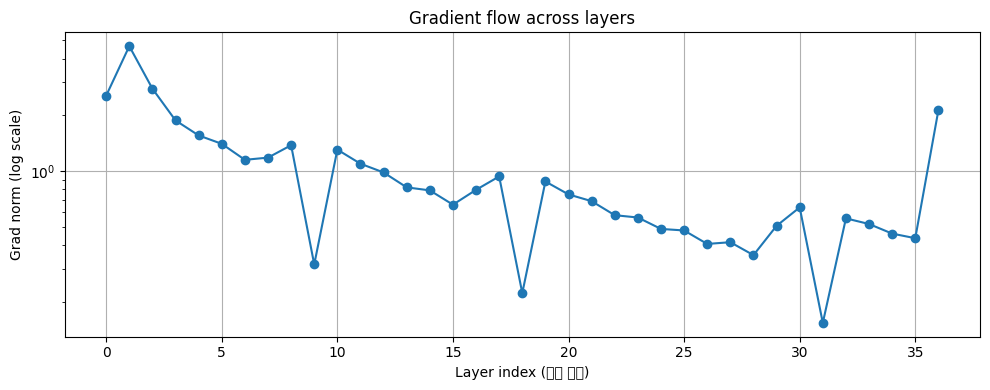

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RESnet().to(device)        # 네가 쓰는 ResNet
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 1. 한 배치만 forward & backward
inputs, labels = next(iter(trainloader))
inputs, labels = inputs.to(device), labels.to(device)

model.train()
optimizer.zero_grad()
outputs = model(inputs)
loss = criterion(outputs, labels)
loss.backward()

# 2. 각 레이어 weight의 grad norm 모으기
layer_names = []
grad_norms = []

for name, p in model.named_parameters():
    if p.grad is None:
        continue
    if p.dim() > 1:   # bias 말고 weight만 보자 (Conv, Linear 등)
        layer_names.append(name)
        grad_norms.append(p.grad.detach().norm().item())



In [12]:

model = RESnet(skip_connection=False).to(device)        # 네가 쓰는 ResNet
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 1. 한 배치만 forward & backward
inputs, labels = next(iter(trainloader))
inputs, labels = inputs.to(device), labels.to(device)

model.train()
optimizer.zero_grad()
outputs = model(inputs)
loss = criterion(outputs, labels)
loss.backward()

# 2. 각 레이어 weight의 grad norm 모으기
layer_names2 = []
grad_norms2 = []

for name, p in model.named_parameters():
    if p.grad is None:
        continue
    if p.dim() > 1:   # bias 말고 weight만 보자 (Conv, Linear 등)
        layer_names2.append(name)
        print(name)
        grad_norms2.append(p.grad.detach().norm().item())



feature_extractor.0.weight
feature_extractor.3.conv1.weight
feature_extractor.3.conv2.weight
feature_extractor.4.conv1.weight
feature_extractor.4.conv2.weight
feature_extractor.5.conv1.weight
feature_extractor.5.conv2.weight
feature_extractor.6.conv1.weight
feature_extractor.6.conv2.weight
feature_extractor.7.conv1.weight
feature_extractor.7.conv2.weight
feature_extractor.8.conv1.weight
feature_extractor.8.conv2.weight
feature_extractor.9.conv1.weight
feature_extractor.9.conv2.weight
feature_extractor.10.conv1.weight
feature_extractor.10.conv2.weight
feature_extractor.11.conv1.weight
feature_extractor.11.conv2.weight
feature_extractor.12.conv1.weight
feature_extractor.12.conv2.weight
feature_extractor.13.conv1.weight
feature_extractor.13.conv2.weight
feature_extractor.14.conv1.weight
feature_extractor.14.conv2.weight
feature_extractor.15.conv1.weight
feature_extractor.15.conv2.weight
feature_extractor.16.conv1.weight
feature_extractor.16.conv2.weight
feature_extractor.17.conv1.weight
f

C:\Users\tkdwl\AppData\Local\Temp\ipykernel_199772\3345496066.py:10: UserWarning: Glyph 44618 (\N{HANGUL SYLLABLE GIP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tkdwl\AppData\Local\Temp\ipykernel_199772\3345496066.py:10: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tkdwl\AppData\Local\Temp\ipykernel_199772\3345496066.py:10: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tkdwl\AppData\Local\Temp\ipykernel_199772\3345496066.py:10: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44618 (\N{HANGUL SYLLABLE GIP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\IPython\core\pylabtools.py:1

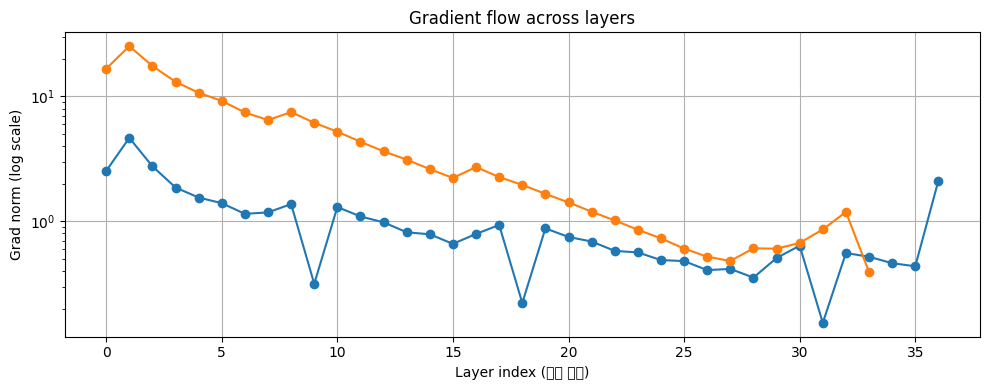

In [11]:
# 3. 깊이 방향으로 그래프 그리기
plt.figure(figsize=(10, 4))
plt.plot(range(len(grad_norms)), grad_norms, marker='o')
plt.plot(range(len(grad_norms2)), grad_norms2, marker='o')
plt.yscale('log')   # 보통 log scale로 보는 게 좋음
plt.xlabel('Layer index (깊이 방향)')
plt.ylabel('Grad norm (log scale)')
plt.title('Gradient flow across layers')
plt.grid(True)
plt.tight_layout()
plt.show()